# Assign points to different groups to minimize regression MSE

Given a series of points, formulate a MIP in order to assign points into groups for linear regression so that the MSE in each regression group can be most minimized. Points assigned to a group must be next to each other. 

Reference:
- [Fuzzy Mixed Integer Optimization Model for Regression Approach](https://arxiv.org/ftp/arxiv/papers/1503/1503.04220.pdf)

## Model

Define $b_{k,i}$ as:
$$ b_{k,i}=\begin{cases}1 \enspace\text{if } x_i \text{ is assigned to group } k \\ 0 \enspace\text{otherwise} \end{cases} $$

$$ \text{min}_{\boldsymbol{B}, \boldsymbol{\delta}, \boldsymbol{\beta}} \enspace\enspace \sum_{i=1}^{n} \delta_i $$
$$ \text{s.t.} \enspace\enspace \delta_i \geq (y_i - \beta_k x_i) - M(1 - b_{k,i}), \enspace\enspace \forall k \in \mathbb{K}, i \in \mathbb{N} $$
$$ \enspace\enspace \delta_i \geq -(y_i - \beta_k x_i) - M(1 - b_{k,i}), \enspace\enspace \forall k \in \mathbb{K}, i \in \mathbb{N} $$
$$ \sum_{k=1}^K b_{k,i} = 1, \delta_i \geq 0, \forall i \in \mathbb{N} $$
$$ a_{k,i} \in \mathbb{B} $$

Please note that $M$ and $K$ are parameters to be set.

## Package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function
import sys
import cplex
from cplex.exceptions import CplexError
from gurobipy import *

## Example

In the example below, there are 9 points which can be assigned to 3 groups in order to most minimize the MSE, the regression error.

In [2]:
y = [1,3,4, 11, 11.5,14,  24,26, 30]

In [3]:
x = list(range(1,len(y)+1))

In [4]:
def connectPoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-')

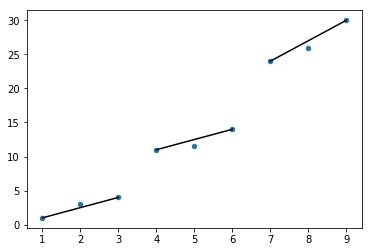

In [5]:
plt.scatter(x,y,s=20)
connectPoints(x,y,0,2)
connectPoints(x,y,3,5)
connectPoints(x,y,6,8)
plt.show()

## Parameters

In [6]:
M = 999
no_K = 3

## Code - Cplex

In [7]:
no_I = len(x)

optSense = "min"

colNames = ["beta_" + str(i) for i in range(1,no_I+1)] \
         + ["delta_" + str(i) for i in range(1,no_I+1)] \
         + ["b_" + str(k) + "_" + str(i) for k in range(1,no_K+1) for i in range(1,no_I+1)] 

varType = "C" * no_I + "C" * no_I + "B" * (no_I * no_K)

c = [0 for i in range(1,no_I+1)] \
    + [1 for i in range(1,no_I+1)] \
    + [0 for k in range(1,no_K+1) for i in range(1,no_I+1)]

For the constraint $\delta_i \geq (y_i - \beta_k x_i) - M(1 - b_{k,i}), \enspace\enspace \forall k \in \mathbb{K}, i \in \mathbb{N}$:

In [8]:
A, b, senses = [], [], ""
for i in range(1,no_I+1):
    for k in range(1,no_K+1):
        A.append([ \
            ["beta_" + str(k), "delta_" + str(i), "b_" + str(k) + "_" + str(i)], \
            [x[i-1], 1, -M] \
        ])
        b.append(y[i-1]-M)
        senses += "G"

For the constraint $\delta_i \geq -(y_i - \beta_k x_i) - M(1 - b_{k,i}), \enspace\enspace \forall k \in \mathbb{K}, i \in \mathbb{N}$:

In [9]:
for i in range(1,no_I+1):
    for k in range(1,no_K+1):
        A.append([ \
            ["beta_" + str(k), "delta_" + str(i), "b_" + str(k) + "_" + str(i)], \
            [-x[i-1], 1, -M] \
        ])
        b.append(-y[i-1]-M)
        senses += "G"

For the constraint $ \sum_{k=1}^K b_{k,i} = 1, \forall i \in \mathbb{N} $:

In [10]:
for i in range(1, no_I+1):
    A.append([ \
            ["b_" + str(k) + "_" + str(i) for k in range(1,no_K+1)], \
            [1 for k in range(1, no_K+1)], \
    ])
    b.append(1)
    senses += "E"

For variable bounds and other settings:

In [11]:
u = [cplex.infinity] * (no_I + no_I + no_I * no_K)
l = [-cplex.infinity] * no_I + [0] * no_I + [0] * (no_I * no_K)
saveOpt = False
saveFile = 'regression_MSE'
quietOpt = False

In [12]:
def mip_cplex(A, b, c, u, l, varType, optSense, senses, saveOpt, colNames, saveFile, quietOpt):

    noRow, noCol = len(A), len(A[0])
    
    my_prob = cplex.Cplex()
    if optSense == 'min':
        my_prob.objective.set_sense(my_prob.objective.sense.minimize)
    elif optSense == 'max':
        my_prob.objective.set_sense(my_prob.objective.sense.maximize)

    my_prob.variables.add(obj=c, ub=u, lb=l, types=varType, names=colNames)
    
    my_prob.linear_constraints.add(lin_expr=A, senses=senses, rhs=b)
    
    if quietOpt:
        my_prob.set_log_stream(None)
        my_prob.set_error_stream(None)
        my_prob.set_warning_stream(None)
        my_prob.set_results_stream(None)
    
    try:
        my_prob.solve()
        if saveOpt:
            my_prob.write( saveFile + ".lp")
            print("LP saved as " + saveFile + ".lp")

        x = my_prob.solution.get_values()
        obj = my_prob.solution.get_objective_value()
        return x, obj
    except CplexError as exc:
        print(exc)
        return [], -1

In [13]:
%%time
sol, obj_cplex = mip_cplex(A, b, c, u, l, varType, optSense, senses, saveOpt, colNames, saveFile, quietOpt)
print(obj_cplex)

CPXPARAM_Read_DataCheck                          1
Found incumbent of value 27.595238 after 0.00 sec. (0.01 ticks)


Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 6 columns.
Reduced MIP has 63 rows, 39 columns, and 189 nonzeros.
Reduced MIP has 27 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.08 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 63 rows, 39 columns, and 189 nonzeros.
Reduced MIP has 27 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.13 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Clique table members: 9.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.07 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           27.5952        0.0000           100.00%
*     0+    0                           25.7500        0.0000     

In [14]:
print("Beta coefficient is")
print(sol[0:no_I])

Beta coefficient is
[3.333333333333333, 1.3333333333333333, 2.333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [15]:
print("Delta coefficient is")
print(sol[no_I:2*no_I])

Delta coefficient is
[0.33333333333333326, 0.3333333333333335, 0.0, 1.6666666666666679, 0.1666666666666643, 0.0, 0.6666666666666679, 0.6666666666666643, 0.0]


In [16]:
old_B = sol[2*no_I:]
consolidated_B = []
idx = 0

print("B coefficient is")
print(old_B)
print("------------")
for k in range(1,no_K+1):
    print(["%.0f" % abs(elem) for elem in old_B[idx:idx+no_I]])
    idx += no_I

B coefficient is
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
------------
['0', '0', '0', '0', '0', '0', '1', '1', '1']
['1', '1', '1', '0', '0', '0', '0', '0', '0']
['0', '0', '0', '1', '1', '1', '0', '0', '0']


## Code - Gurobi

Reference: 
- [Github - wurmen - Prototype example type 2](https://github.com/wurmen/Gurobi-Python/blob/master/python-gurobi%20%20model/Prototype%20example_type2.md)
- [Github - wurmen - Optimal employee schedule](https://github.com/wurmen/Gurobi-Python/blob/master/python-gurobi%20%20model/Optimal%20Employee%20Work%20Schedule.md)

In [17]:
def mip_gurobi(x, y, M):
    m = Model('mip')
#     m.setParam('OutputFlag',0)
    
    beta, delta, B = {}, {}, {}
    
    for k in range(no_K):
        beta[k] = m.addVar(vtype=GRB.CONTINUOUS, name="beta_"+str(k))
        
    for i in range(no_I):
        delta[i] = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name="delta_"+str(i))
        for k in range(no_K):
            B[k,i] = m.addVar(vtype=GRB.BINARY, name="B_"+str(k)+"_"+str(i))
    
    m.setObjective(quicksum(delta[i] for i in range(no_I)), GRB.MINIMIZE)
    
    for i in range(no_I):
        m.addConstr(quicksum(B[k,i] for k in range(no_K)) == 1)
        for k in range(no_K):
            m.addConstr(delta[i] >= y[i] - beta[k] * x[i] - M + M * B[k,i])
            m.addConstr(delta[i] >= -y[i] + beta[k] * x[i] - M + M * B[k,i])

    m.update()
    m.optimize()

    return m.objVal, GRB.Status.OPTIMAL, m.getAttr('x', beta), m.getAttr('x', delta), m.getAttr('x', B)

In [18]:
%%time
obj_gurobi, status, beta, delta, B = mip_gurobi(x, y, M)
print(obj_gurobi)

Optimize a model with 63 rows, 39 columns and 189 nonzeros
Variable types: 12 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 124.5
Presolve removed 6 rows and 0 columns
Presolve time: 0.00s
Presolved: 57 rows, 39 columns, 171 nonzeros
Variable types: 12 continuous, 27 integer (27 binary)

Root relaxation: objective 0.000000e+00, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   15  124.50000    0.00000   100%     -    0s
H    0     0                      10.8333333    0.00000   100%     -    0s
H    0     0                       3.8333333    0.00000   100%     -    0s
     0     0    0.00000    0   19    3.83333    0.00000   100%     -    0s
     

In [19]:
print("Beta coefficient is")
print(beta)
print("------------")
print([beta[elem] for elem in range(no_K)])

Beta coefficient is
{0: 1.3333333333333466, 1: 3.333333333333325, 2: 2.333333333333324}
------------
[1.3333333333333466, 3.333333333333325, 2.333333333333324]


In [20]:
print("Delta coefficient is")
print(delta)
print("------------")
print([delta[elem] for elem in range(no_I)])

Delta coefficient is
{0: 0.3333333333333328, 1: 0.3333333333332864, 2: 0.0, 3: 1.6666666666666643, 4: 0.16666666666666785, 5: 0.0, 6: 0.6666666666666785, 7: 0.6666666666666075, 8: 0.0}
------------
[0.3333333333333328, 0.3333333333332864, 0.0, 1.6666666666666643, 0.16666666666666785, 0.0, 0.6666666666666785, 0.6666666666666075, 0.0]


In [21]:
print("B coefficient is")
print(B)
print("------------")
for k in range(no_K):
    print([abs(B[k, i]) for i in range(no_I)])

B coefficient is
{(2, 7): 0.0, (2, 6): 0.0, (2, 8): 0.0, (2, 2): 0.0, (2, 1): 0.0, (1, 3): 0.0, (1, 6): 1.0, (1, 4): 0.0, (0, 4): 0.0, (1, 0): 0.0, (2, 0): 0.0, (2, 5): 1.0, (1, 2): 0.0, (0, 8): 0.0, (0, 5): 0.0, (0, 2): 1.0, (0, 6): 0.0, (0, 0): 1.0, (2, 4): 1.0, (1, 5): 0.0, (1, 8): 1.0, (1, 7): 1.0, (2, 3): 1.0, (0, 1): 1.0, (0, 7): 0.0, (0, 3): 0.0, (1, 1): 0.0}
------------
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
